## Subject Selection Experiments disorder data - Srinivas (handle: thewickedaxe)

### Initial Data Cleaning

In [1]:
# Standard
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# Dimensionality reduction and Clustering
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn import manifold, datasets
from itertools import cycle

# Plotting tools and classifiers
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut


# Let's read the data in and clean it

def get_NaNs(df):
    columns = list(df.columns.get_values()) 
    row_metrics = df.isnull().sum(axis=1)
    rows_with_na = []
    for i, x in enumerate(row_metrics):
        if x > 0: rows_with_na.append(i)
    return rows_with_na

def remove_NaNs(df):
    rows_with_na = get_NaNs(df)
    cleansed_df = df.drop(df.index[rows_with_na], inplace=False)     
    return cleansed_df

initial_data = pd.DataFrame.from_csv('Data_Adults_1_reduced_inv2.csv')
cleansed_df = remove_NaNs(initial_data)

# Let's also get rid of nominal data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X = cleansed_df.select_dtypes(include=numerics)
print X.shape

(5527, 70)


In [3]:
# Let's now clean columns getting rid of certain columns that might not be important to our analysis

cols2drop = ['GROUP_ID', 'doa', 'Baseline_header_id', 'Concentration_header_id']
X = X.drop(cols2drop, axis=1, inplace=False)
print X.shape

# For our studies children skew the data, it would be cleaner to just analyse adults
X = X.loc[X['Age'] >= 18]
Y = X.loc[X['race_id'] == 1]
X  = X.loc[X['Gender_id'] == 1]

print X.shape
print Y.shape

(5527, 66)
(3327, 66)
(3700, 66)


### Extracting the samples we are interested in

In [4]:
# Let's extract ADHd and Bipolar patients (mutually exclusive)

ADHD_men = X.loc[X['ADHD'] == 1]
ADHD_men = ADHD_men.loc[ADHD_men['Bipolar'] == 0]

BP_men = X.loc[X['Bipolar'] == 1]
BP_men = BP_men.loc[BP_men['ADHD'] == 0]

ADHD_cauc = Y.loc[Y['ADHD'] == 1]
ADHD_cauc = ADHD_cauc.loc[ADHD_cauc['Bipolar'] == 0]

BP_cauc = Y.loc[Y['Bipolar'] == 1]
BP_cauc = BP_cauc.loc[BP_cauc['ADHD'] == 0]

print ADHD_men.shape
print BP_men.shape

print ADHD_cauc.shape
print BP_cauc.shape

# Keeping a backup of the data frame object because numpy arrays don't play well with certain scikit functions
ADHD_men = pd.DataFrame(ADHD_men.drop(['Patient_ID', 'Gender_id', 'ADHD', 'Bipolar'], axis = 1, inplace = False))
BP_men = pd.DataFrame(BP_men.drop(['Patient_ID', 'Gender_id', 'ADHD', 'Bipolar'], axis = 1, inplace = False))

ADHD_cauc = pd.DataFrame(ADHD_cauc.drop(['Patient_ID', 'race_id', 'ADHD', 'Bipolar'], axis = 1, inplace = False))
BP_cauc = pd.DataFrame(BP_cauc.drop(['Patient_ID', 'race_id', 'ADHD', 'Bipolar'], axis = 1, inplace = False))

(1326, 66)
(343, 66)
(1379, 66)
(406, 66)


### Dimensionality reduction

#### Manifold Techniques

##### ISOMAP

In [5]:
combined1 = pd.concat([ADHD_men, BP_men])
combined2 = pd.concat([ADHD_cauc, BP_cauc])

print combined1.shape
print combined2.shape

combined1 = preprocessing.scale(combined1)
combined2 = preprocessing.scale(combined2)

(1669, 62)
(1785, 62)


In [6]:
combined1 = manifold.Isomap(20, 20).fit_transform(combined1)
ADHD_men_iso = combined1[:1326]
BP_men_iso = combined1[1326:]

combined2 = manifold.Isomap(20, 20).fit_transform(combined2)
ADHD_cauc_iso = combined2[:1379]
BP_cauc_iso = combined2[1379:]

### Clustering and other grouping experiments

#### K-Means clustering - iso

In [7]:
data1 = pd.concat([pd.DataFrame(ADHD_men_iso), pd.DataFrame(BP_men_iso)])
data2 = pd.concat([pd.DataFrame(ADHD_cauc_iso), pd.DataFrame(BP_cauc_iso)])

print data1.shape
print data2.shape

(1669, 20)
(1785, 20)


Estimated number of clusters: 2


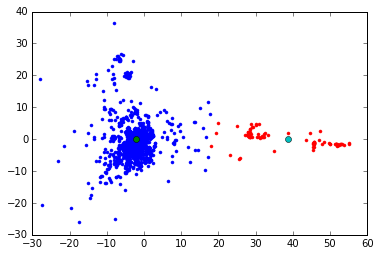

In [8]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data1.get_values())
labels1 = kmeans.labels_
centroids1 = kmeans.cluster_centers_
print('Estimated number of clusters: %d' % len(centroids1))

for label in [0, 1]:
    ds = data1.get_values()[np.where(labels1 == label)]    
    plt.plot(ds[:,0], ds[:,1], '.')    
    lines = plt.plot(centroids1[label,0], centroids1[label,1], 'o')



Estimated number of clusters: 2


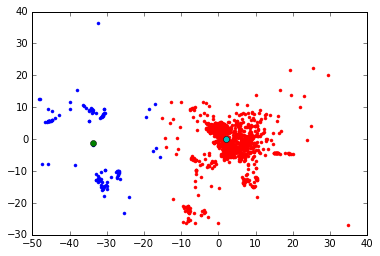

In [9]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(data2.get_values())
labels2 = kmeans.labels_
centroids2 = kmeans.cluster_centers_
print('Estimated number of clusters: %d' % len(centroids2))

for label in [0, 1]:
    ds2 = data2.get_values()[np.where(labels2 == label)]    
    plt.plot(ds2[:,0], ds2[:,1], '.')    
    lines = plt.plot(centroids2[label,0], centroids2[label,1], 'o')

As is evident from the above 2 experiments, no clear clustering is apparent.But there is some significant overlap and there 2 clear groups

### Classification Experiments

Let's experiment with a bunch of classifiers

In [10]:
ADHD_men_iso = pd.DataFrame(ADHD_men_iso)
BP_men_iso = pd.DataFrame(BP_men_iso)

ADHD_cauc_iso = pd.DataFrame(ADHD_cauc_iso)
BP_cauc_iso = pd.DataFrame(BP_cauc_iso)

In [11]:
BP_men_iso['ADHD-Bipolar'] = 0
ADHD_men_iso['ADHD-Bipolar'] = 1

BP_cauc_iso['ADHD-Bipolar'] = 0
ADHD_cauc_iso['ADHD-Bipolar'] = 1

data1 = pd.concat([ADHD_men_iso, BP_men_iso])
data2 = pd.concat([ADHD_cauc_iso, BP_cauc_iso])
class_labels1 = data1['ADHD-Bipolar']
class_labels2 = data2['ADHD-Bipolar']
data1 = data1.drop(['ADHD-Bipolar'], axis = 1, inplace = False)
data2 = data2.drop(['ADHD-Bipolar'], axis = 1, inplace = False)
data1 = data1.get_values()
data2 = data2.get_values()

In [12]:
# Leave one Out cross validation
def leave_one_out(classifier, values, labels):
    leave_one_out_validator = LeaveOneOut(len(values))
    classifier_metrics = cross_validation.cross_val_score(classifier, values, labels, cv=leave_one_out_validator)
    accuracy = classifier_metrics.mean()
    deviation = classifier_metrics.std()
    return accuracy, deviation

In [13]:
rf = RandomForestClassifier(n_estimators = 22) 
qda = QDA()
lda = LDA()
gnb = GaussianNB()
classifier_accuracy_list = []
classifiers = [(rf, "Random Forest"), (lda, "LDA"), (qda, "QDA"), (gnb, "Gaussian NB")]
for classifier, name in classifiers:
    accuracy, deviation = leave_one_out(classifier, data1, class_labels1)
    print '%s accuracy is %0.4f (+/- %0.3f)' % (name, accuracy, deviation)
    classifier_accuracy_list.append((name, accuracy))

Random Forest accuracy is 0.9772 (+/- 0.149)
LDA accuracy is 0.9766 (+/- 0.151)
QDA accuracy is 0.9569 (+/- 0.203)
Gaussian NB accuracy is 0.9593 (+/- 0.198)


In [14]:
for classifier, name in classifiers:
    accuracy, deviation = leave_one_out(classifier, data2, class_labels2)
    print '%s accuracy is %0.4f (+/- %0.3f)' % (name, accuracy, deviation)
    classifier_accuracy_list.append((name, accuracy))

Random Forest accuracy is 0.9686 (+/- 0.174)
LDA accuracy is 0.9529 (+/- 0.212)
QDA accuracy is 0.9518 (+/- 0.214)
Gaussian NB accuracy is 0.9429 (+/- 0.232)
